In [1]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use(['dark_background'])

In [2]:

#filepath = '/home/pgrover/working/working/Paper_4_Turbulence_Modelling/FlumeExperiment/geometries/flume_profile_smoothed.txt'
filepath = 'flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
retval = collections.OrderedDict()


z = []
with open(filepath) as f:
    for line in f:
        values = line.split()
        if is_number(values[0])==False:
            if float(values[1]).is_integer():
                retval[values[0]]=int(values[1])
            else:
                retval[values[0]]=float(values[1])
        else:
            z.append(float(values[0]))
z = np.array(z)
print('Z: {0}'.format(len(z)))
xmax = float(retval['nrows']) * retval['cellsize']
nx = retval['nrows']
dx = retval['cellsize']

#--------------------------------
# Increase the resolution on the grid
#--------------------------------
resolution = 2
x = np.linspace(0, nx*dx, num=len(z))
f = interp1d(x, z)
xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
znew = f(xnew)
nx = len(xnew)

print('Finished reinterpolating the grid nx={0}'.format(len(xnew)))


Z: 87
Finished reinterpolating the grid nx=174


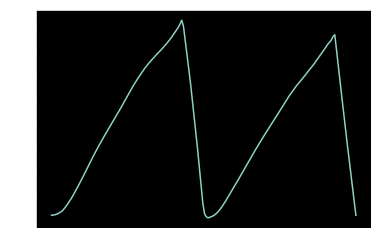

In [3]:
plt.plot(xnew,znew)

In [6]:
#--------------------------------
# Set up the constants
#--------------------------------
s= 0.2      # Surface water elevation
beta = 0.01

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

x = pyclaw.Dimension(0.0,xmax,len(xnew),name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

zc = znew.copy()
z_hydro = znew.copy()

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0


# Set up the inital state of the flow
zc20 = zc
Slope = 1/792.
shw_slvr = shallow_solver(domain, slope=Slope, mannings=0.022)
u20, surf20,h20 = shw_slvr.run(zc,0.2, 120)


if np.isnan(u20).any():
    # Get the flow
    print( u20)
    raise ValueError('Failed to calculate the flow')



Grid dx = 0.015
Grid nx = 174
2019-04-08 20:26:34,940 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-08 20:26:42,634 INFO CLAW: Solution 1 computed for time t=82.300615


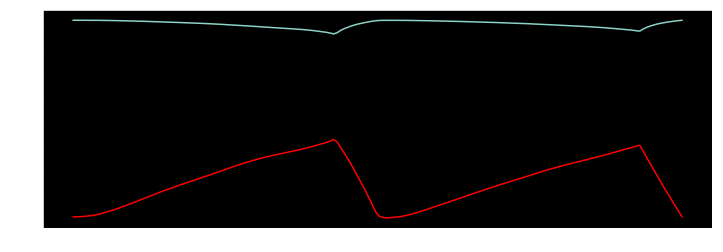

In [7]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf20)
plt.plot(xc,zc20,'r')

0.4299808693200725

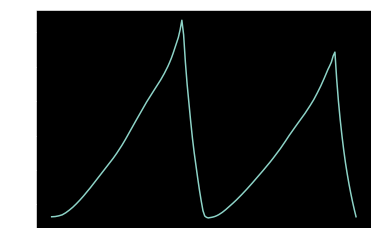

In [8]:
plt.plot(xc, u20)

u20.mean()

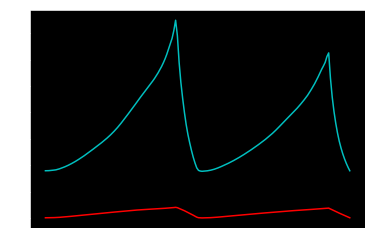

In [7]:
tau20 = np.zeros(nx)
for i in range(0,nx): #i=2
    tau20[i] = sedtrans.get_bed_shear(h20[i],u20[i],D50)
    
plt.plot(xc,tau20,'c-')

plt.plot(xc,zc,'r')



In [8]:
fig = plt.figure(figsize=(16, 3))
# Set up the inital state of the flow
shw_slvr = shallow_solver(domain, slope=Slope, mannings=0.022)
u32, surf32,h32 = shw_slvr.run(zc,0.32)

tau32 = np.zeros(nx)
for i in range(0,nx): #i=2
    tau32[i] = sedtrans.get_bed_shear(h32[i],u32[i],D50)
    
print('Mean u {0}'.format(u32.mean()))

2019-04-08 19:51:13,832 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-08 19:51:23,829 INFO CLAW: Solution 1 computed for time t=65.561031
Mean u 0.5628329873987873


<Figure size 1152x216 with 0 Axes>

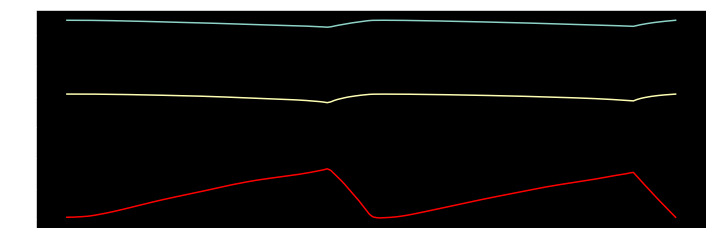

In [9]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf32)
plt.plot(xc,surf20)
plt.plot(xc,zc20,'r')

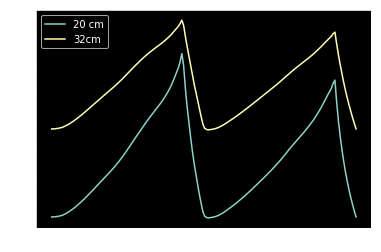

In [10]:
plt.plot(xc, u20, label='20 cm')
plt.plot(xc, u32, label='32cm')
plt.legend()

In [4]:
tau_cr = sedtrans.get_critical_shear(D50, rho_particule)
fig = plt.figure(figsize=(12, 8))
plt.axhline(tau_cr)
plt.plot(xc,tau32,'c-',label='32 cm')
plt.plot(xc,tau20,'g-', label='20 cm')
plt.plot(xc,zc*1.5,'r')
plt.ylim([-1., 4.5])
plt.ylabel('Shear Stress (Pa)')
plt.legend()

NameError: name 'D50' is not defined

In [12]:
import pandas as pd
filepath = r'/data/PhD/LRN-WallTreatments-openFOAM-5.x/validation/QueensFlume/32.cm/dune.127z.30r.colebrook.yp.0.x/30/wallShearStress.txt'
tau32df = pd.read_csv(filepath, sep='\t', index_col=0)

filepath = r'/data/PhD/LRN-WallTreatments-openFOAM-5.x/validation/QueensFlume/20.cm/dune.100z.30r.colebrook.yp.0.x/30/wallShearStress.txt'
tau20df = pd.read_csv(filepath, sep='\t', index_col=0)

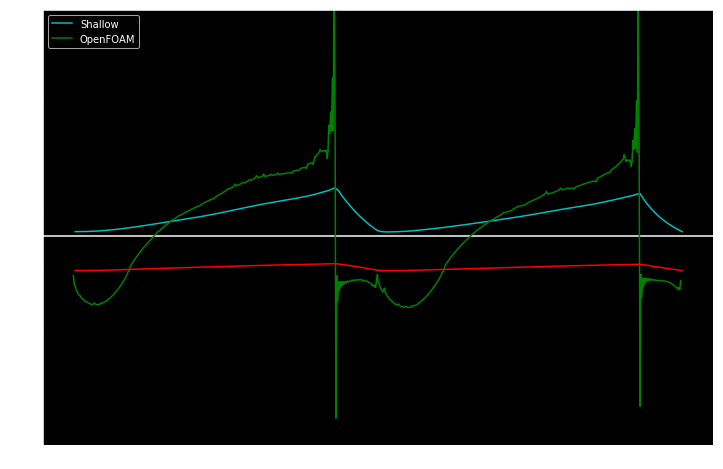

In [13]:
tau_cr = sedtrans.get_critical_shear(D50, rho_particule)
fig = plt.figure(figsize=(12, 8))
plt.axhline(tau_cr)
plt.plot(xc,tau32,'c-',label='Shallow')
plt.plot(tau32df.index,tau32df.tau,'g-', label='OpenFOAM')
plt.plot(xc,zc*1.5,'r')
plt.ylim([-3., 4.5])
plt.ylabel('Shear Stress (Pa)')
plt.legend()

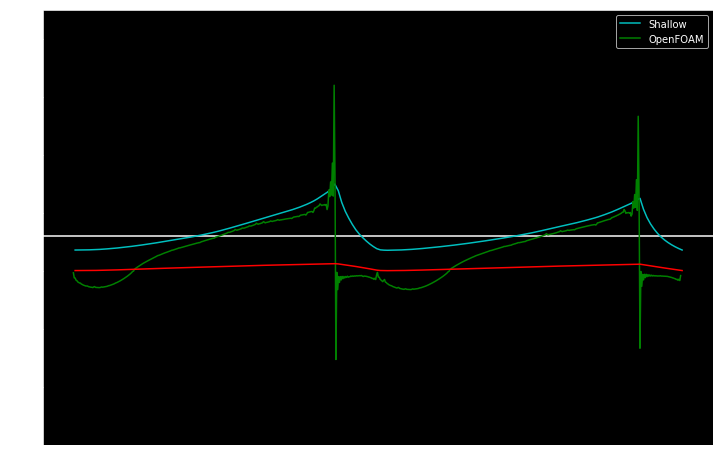

In [14]:
tau_cr = sedtrans.get_critical_shear(D50, rho_particule)
fig = plt.figure(figsize=(12, 8))
plt.axhline(tau_cr)
plt.plot(xc,tau20,'c-',label='Shallow')
plt.plot(tau20df.index,tau20df.tau,'g-', label='OpenFOAM')
plt.plot(xc,zc*1.5,'r')
plt.ylim([-3., 4.5])
plt.ylabel('Shear Stress (Pa)')
plt.legend()